<h1>Assessment 2 - Image Classification model for brain tumor detection (using CT scans images) </h1>


In [141]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

np.random.seed(24775456)
random.seed(24775456)

## Check the amount of files afterdownloading and unzipping

In [147]:
import os
print(os.getcwd())



count = 0
for label in os.listdir(os.path.join('/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset', 'train')):
    for f in os.listdir(os.path.join('/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset', 'train', label)):
        count += 1

print('train: ', count)




count = 0
for label in os.listdir(os.path.join('/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset', 'test')):
    label_path = os.path.join('/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset', 'test', label)
    if os.path.isdir(label_path):
        for f in os.listdir(label_path):
            count += 1

print('test: ', count)

/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Model
train:  5000
test:  1000


# Custom function for confusion matrix:


In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def custom_cf(color, y_test, y_pred, test_accuracy):
    labels = np.unique(y_test)

    cm = confusion_matrix(y_test, y_pred, labels=labels)

    decoded_labels = le.inverse_transform(labels)


    # Plot confusion matrix:
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=plt.get_cmap(color), square=True, linewidths=0.5, xticklabels=decoded_labels, yticklabels=decoded_labels)


In [70]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

import os
import cv2
import numpy as np
def data_loader(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        for file in os.listdir(os.path.join(directory, label)):
            images.append(cv2.imread(os.path.join(directory, label, file)))
            labels.append(label)
    # Normalising
    images = np.array(images)/255.0
    labels = le.fit_transform(labels)
    return images, labels


# Declare train and test


In [ ]:
train_dir = '/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset/train'
test_dir = '/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset/test'
val_dir = '/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset/val'

In [126]:
import os

def anonymize_filenames(folder_path, prefix):
    for i, filename in enumerate(os.listdir(folder_path)):
        ext = os.path.splitext(filename)[1]
        new_name = f"{prefix}_{i:04d}{ext}"
        os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_name))

anonymize_filenames("/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset/train/Healthy", "img")
anonymize_filenames("/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset/train/Tumor", "img")
anonymize_filenames("/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset/test/Healthy", "img")
anonymize_filenames("/Users/duonganhtran/Documents/Lecture Notes/Ongoing/31005 Machine Learning/Assessment/Assessment 2/Dataset/test/Tumor", "img")

# Model Creation

In [127]:
import torch

print("MPS Available:", torch.backends.mps.is_available())
print("MPS Built:", torch.backends.mps.is_built())

MPS Available: True
MPS Built: True


In [139]:
import torch
print(torch.__version__)

from torch import nn
from torchvision import models as torch_model
from torchvision.models import ResNet50_Weights

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def make_model():
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print("Using device:", device)
    model = torch_model.mobilenet_v2(weights=None)

    for param in model.parameters():
        param.requires_grad = True

    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(model.last_channel, 1)

    #resNet50 = torch.compile(resNet50)
    model.to(device)

    # Currently testing with default values
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    return model, criterion, optimizer


2.8.0


Prepare dataset

In [ ]:
from torchvision import datasets, transforms
import torch


transformation = transforms.Compose([
    # Getting 3 channels to match ResNet input channels
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),

    # Normalising using the mean and standard deviation of ImageNet dataset as this model is pretrained
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# transformation for training only
augmentTransform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.GaussianBlur(kernel_size=3),
    

    #because the model is too good i p-ut color jittering and lighting change
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


#This is the training set
train_pad_dir = datasets.ImageFolder(root=train_dir, transform=augmentTransform)
test_pad_dir = datasets.ImageFolder(root=test_dir, transform=transformation)
val_pad_dir = datasets.ImageFolder(root=val_dir, transform=transformation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


{'Healthy': 0, 'Tumor': 1}


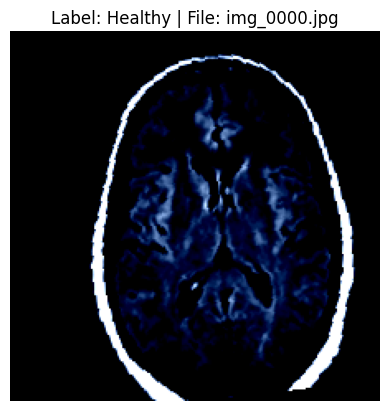

In [135]:
print(train_pad_dir.class_to_idx)

import matplotlib.pyplot as plt

img, label = train_pad_dir[0]
img_path, _ = train_pad_dir.samples[0]  # (path, label)

# Extract just the filename
filename = os.path.basename(img_path)

# Display
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {train_pad_dir.classes[label]} | File: {filename}")
plt.axis('off')
plt.show()

Training

In [77]:
!pip install torchmetrics


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [131]:
print(device)

mps


In [ ]:
from sklearn.model_selection import StratifiedKFold as SKF
import numpy as np
import time
from torch.utils.data import Subset, DataLoader
import torch
from torchmetrics.classification import BinaryAccuracy
from torch.utils.data import DataLoader

train_loader = DataLoader(train_pad_dir, batch_size=32, shuffle=True)
val_loader = DataLoader(val_pad_dir, batch_size=32, shuffle=False)
model, criterion, optimizer = make_model()

# Perform model training
num_epochs = 50
for epoch in range(num_epochs):
    s = time.perf_counter()
    model.train()
    train_loss = 0
    train_acc = BinaryAccuracy().to(device)


    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        #Reset gradient first
        optimizer.zero_grad()

        train_pred = model(images)
        train_pred_probs = torch.sigmoid(train_pred)
        train_acc.update(train_pred_probs, labels)

        # Calculate loss
        loss = criterion(train_pred, labels)

        # Back prop + Optimise
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_accuracy = train_acc.compute()
    e = time.perf_counter()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Time: {e-s}")
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

    # Start validating
    model.eval()
    correct = 0
    total = 0

    val_loss = 0
    val_acc = BinaryAccuracy().to(device)

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            val_pred = model(images)

            v_loss = criterion(val_pred, labels)
            val_loss += v_loss.item()

            val_pred_probs = torch.sigmoid(val_pred)
            val_acc.update(val_pred_probs, labels)

    val_loss /= len(val_loader)
    val_accuracy = val_acc.compute()
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    print('-' * 50)

Using device: mps


KeyboardInterrupt: 

Testing

In [138]:
# Evaluation with test data
test_loader = DataLoader(test_pad_dir, batch_size=32, shuffle=False)
model.eval()

test_loss = 0
test_acc = BinaryAccuracy().to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        test_pred = model(images)

        t_loss = criterion(test_pred, labels)
        test_loss += t_loss.item()

        test_pred_probs = torch.sigmoid(test_pred)
        test_acc.update(test_pred_probs, labels)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc.compute():.4f}')
print('-' * 50)


Test Loss: 6.9608, Test Accuracy: 0.8867
--------------------------------------------------
